In [2]:
import numpy as np
import pandas as pd
import os
import data_processing as dp
from sklearn.preprocessing import StandardScaler
import time
import h5py
import pywt
from scipy.fft import fft
from scipy import signal
from scipy.integrate import cumtrapz
from itertools import permutations,combinations
import matplotlib.pyplot as plt

In [ ]:
# Summarize labels in each file and save them to csv file

df = pd.DataFrame(index=[0,1,2,3,4,5,6])
for dirname,_,filenames in os.walk('E:\Document\教材\Master thesis\data'):
    for filename in filenames:
        dir_depth = len(dirname.split(os.path.sep))
        if dir_depth == 5:
            if filename.endswith('.csv'):
                file = os.path.join(dirname,filename)
                emg_data = pd.read_csv(file)
                try:
                    emg_data.Label2
                except AttributeError:
                    continue
                else:
                    info = emg_data.Label2.value_counts()
                    df[filename] = info
                print(info)
            #print(os.path.join(dirname,filename))
df.to_csv('whole_data_info.csv',index=True)
#df.to_csv('whole_data_info.txt',sep='\t',index=True)

In [3]:
# read file name of data with various Labels
df = pd.read_csv('./useful_data_label.csv',index_col=0) 
# read file name of data with only label 0
df2 = pd.read_csv('./unuseful_data_label.csv',index_col=0)
# read some of the data with only label 0
df3 = pd.read_csv('./data/file_name.txt',header=None)

In [24]:
width = 256
stride = 64
threshold_WAMP = 30
threshold_ZC = 0
threshold_SSC = 1
bins=9
bound = 70
HIST_range = (-bound,bound)

In [219]:
import imp
imp.reload(dp)

<module 'data_processing' from 'E:\\Document\\jupyter\\Master Thesis\\data_processing.py'>

In [11]:
#generate features
files = np.concatenate([np.array(df.columns),np.array('正常/'+df3.loc[:,0])])
widths = [256]

for width in widths:
    features = []
    labels = []
    stride = width//4
    for file in files:
        if file == ']]P379_M050_2_OFF_A_FoG_trial_1_emg.csv':
            continue
        print(file)
        feature,label = dp.pipeline_feature('./data/'+file,width = width, 
                                           stride=stride,
                                           scaler=False,
                                           threshold_WAMP = threshold_WAMP,
                                           threshold_SSC = threshold_SSC,
                                           bins=bins,
                                           ranges=HIST_range,
                                           show_para=False,
                                           filt=None)
        features += feature.tolist()
        labels += label.tolist()
    print('save...')
    print(stride)
    save_file = './processed data/nfeatures_W%d_S%d_WAMP30.hdf5'%(width,stride)
    with h5py.File(save_file,'w') as f:
        f.create_dataset('features',data=np.array(features),
                         chunks = True,dtype = np.float32)
        f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

G04_FoG_trial_1_emg.csv
G04_FoG_trial_2_emg.csv
G06_FoG_trial_1_emg.csv
G06_FoG_trial_2_emg.csv
G06_FoG_trial_3_emg.csv
G07_Freezing_Trial1_trial_1_emg.csv
G08_FoG_1_trial_1_emg.csv
G08_FoG_2_trial_1_emg.csv
G11_FoG_trial_1_emg.csv
G11_FoG_trial_2_emg.csv
P379_M050_2_OFF_A_FoG_trial_1_emg.csv
P379_M050_2_OFF_A_FoG_trial_2_emg.csv
P379_M050_2_OFF_A_FoG_trial_3_emg.csv
P379_M050_2_OFF_B_FoG_trial_1_emg.csv
P379_M050_2_OFF_B_FoG_trial_2_emg.csv
P379_M050_2_OFF_B_FoG_trial_3_emg.csv
P551_M050_2_A_FoG_trial_1_emg.csv
P551_M050_2_B_FoG_trial_1_emg.csv
P551_M050_2_B_FoG_trial_2_emg.csv
P812_M050_2_B_FoG_trial_1_emg.csv
P812_M050_2_B_FoG_trial_2_emg.csv
正常/G02_Walking_trial_1_emg.csv
正常/G03_Walking_trial_1_emg.csv
正常/G03_Walking_trial_2_emg.csv
正常/G05_Walking_struct_fixed_trial_1_emg.csv
正常/G05_Walking_struct_fixed_trial_3_emg.csv
正常/G09_FoG_trial_1_emg.csv
正常/G09_FoG_trial_3_emg.csv
正常/G11_Walking_trial_2_emg.csv
正常/P231_M050_A_Walking_trial_2_emg.csv
正常/P231_M050_A_Walking_trial_4_emg.csv
正常

In [12]:
#generate features of the rest data
ind = df2.iloc[1].isna()
files = df2.columns[ind]
widths = [256]
i = 0
cols = [ 'LEFT_TA','LEFT_TS','LEFT_BF', 'LEFT_RF',
        'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
cols = {'Left':cols[:4],'Right':cols[4:]}
data = False
if data:
    for width in widths:
        X = []
        Y = []
        stride = width//4
        for file in files:
            if file in np.array(df3):
                i += 1
                print('skip')
                continue
            print(file)
            emg_data = pd.read_csv('./data/正常/'+file)
            emg_data = emg_data.fillna({'LEFT_TA':emg_data.LEFT_TA.mean(),
                                        'LEFT_TS':emg_data.LEFT_TS.mean(),
                                        'LEFT_BF':emg_data.LEFT_BF.mean(),
                                        'LEFT_RF':emg_data.LEFT_RF.mean(),
                                        'RIGHT_TA':emg_data.RIGHT_TA.mean(),
                                        'RIGHT_TS':emg_data.RIGHT_TS.mean(),
                                        'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                                        'RIGHT_RF':emg_data.RIGHT_RF.mean()})
            #emg_data = emg_data[emg_data.Label1 == emg_data.Label2].reset_index(drop=True)
            x,y = dp.generate_window_slide_data(emg_data,width=width,stride=stride,scaler=False)
            X += x.tolist()
            Y += y.tolist()
        print('save...')
        print(stride)
        file = './processed data/data_set_after_window_S64_rest.hdf5'
        with h5py.File(file,'w') as f:
            f.create_dataset('cwt_data',data=np.array(X),
                             chunks = True,dtype = np.float32)
            f.create_dataset('label2',data=np.array(Y), dtype = np.int8)
        print('save finished.')
        print(i)
else:
    for width in widths:
        features = []
        labels = []
        stride = width//4
        for file in files:
            if file in np.array(df3):
                i += 1
                print('skip')
                continue
            print(file)
            feature,label = dp.pipeline_feature('./data/正常/'+file,
                                               #columns = cols['Right'],
                                               width = width, 
                                               stride=stride,
                                               threshold_WAMP = threshold_WAMP,
                                               threshold_SSC = threshold_SSC,
                                               bins=bins,
                                               ranges=HIST_range,
                                               show_para=False)
            features += feature.tolist()
            labels += label.tolist()
        print('save...')
        print(stride)
        save_file = './processed data/nfeatures_rest_W%d_S%d.hdf5'%(width,stride)
        with h5py.File(save_file,'w') as f:
            f.create_dataset('features',data=np.array(features),
                             chunks = True,dtype = np.float32)
            f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
        print('save finished.')
        print(i)

skip
skip
skip
skip
G05_Walking_struct_fixed_trial_2_emg.csv
skip
skip
G09_FoG_trial_2_emg.csv
skip
G09_Walking_trial_2_emg.csv
G09_Walking_trial_4_emg.csv
G09_Walking_trial_6_emg.csv
skip
G11_Walking_trial_4_emg.csv
skip
skip
P231_M050_A_Walking_trial_6_emg.csv
P231_M050_B_Walking_trial_2_emg.csv
P231_M050_B_Walking_trial_4_emg.csv
P231_M050_B_Walking_trial_6_emg.csv
P231_M100_2_A_FoG_trial_3_emg.csv
P231_M100_2_A_Walking_trial_4_emg.csv
P231_M100_2_A_Walking_trial_6_emg.csv
P231_M100_ON_A_Walking_trial_2_emg.csv
P231_M100_ON_A_Walking_trial_4_emg.csv
P231_M100_ON_A_Walking_trial_6_emg.csv
P231_Msham_A_Walking_trial_2_emg.csv
P231_Msham_A_Walking_trial_6_emg.csv
P231_Msham_B_Walking_trial_2_emg.csv
skip
P351_M050_2_A_FoG_trial_2_emg.csv
P351_M050_2_A_FoG_trial_3_emg.csv
skip
P351_M050_2_A_Walking_trial_4_emg.csv
P351_M050_2_A_Walking_trial_6_emg.csv
P351_M050_2_B_FoG_trial_1_emg.csv
P351_M050_2_B_FoG_trial_2_emg.csv
P351_M050_2_B_FoG_trial_3_emg.csv
P351_M050_2_B_Walking_trial_2_emg.c

In [77]:
np.array(features).shape

(53005, 84)

In [264]:
#generate features from Left or Right
files = np.concatenate([np.array(df.columns),np.array('正常/'+df3.loc[:,0])])
widths = [256]
#drop_cols = [ 'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
cols = [ 'LEFT_TA','LEFT_TS','LEFT_BF', 'LEFT_RF',
        'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
cols = {'Left':cols[:4],'Right':cols[4:]}
for col in cols:
    features = []
    labels = []
    stride = width//4
    for file in files:
        feature,label = dp.pipeline_selected_feature('./data/'+file,
                                                     columns=cols[col],
                                            width = width, 
                                           stride=stride,
                                           threshold_WAMP = threshold_WAMP,
                                           threshold_SSC = threshold_SSC,
                                           bins=bins,
                                           ranges=HIST_range,
                                           show_para=False)
        features += feature.tolist()
        labels += label.tolist()
    print('save...')
    print(stride)
    #save_file = './processed data/'+col+'_features_W%d_S%d.hdf5'%(width,stride)
    save_file = './processed data/'+col+'_nfeatures_W%d_S%d.hdf5'%(width,stride)
    with h5py.File(save_file,'w') as f:
        f.create_dataset('features',data=np.array(features),
                         chunks = True,dtype = np.float32)
        f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

save...
64
save finished.
save...
64
save finished.


In [90]:
#generate selected features
files = np.concatenate([np.array(df.columns),np.array('正常/'+df3.loc[:,0])])
widths = [256]
cols = ['LTA','LTS','LBF','LRF','RTA','RTS','RBF','RRF']
#drop_cols = [ 'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
cols = [ 'LEFT_TA','LEFT_TS','LEFT_BF', 'LEFT_RF',
        'RIGHT_TA','RIGHT_TS','RIGHT_BF', 'RIGHT_RF']
cols = 
for p in combinations(cols,2):
#for col in cols:
    features = []
    labels = []
    width = 256
    stride = width//4
    #col = [p[0],p[1]]
    for file in files:
        feature,label = dp.pipeline_selected_feature('./data/'+file,
                                                     #columns=col,
                                                     drop_cols = [col],
                                            width = width, 
                                           stride=stride,
                                           threshold_WAMP = threshold_WAMP,
                                           threshold_SSC = threshold_SSC,
                                           bins=bins,
                                           ranges=HIST_range,
                                           show_para=False)
        features += feature.tolist()
        labels += label.tolist()
    print('save...')
    print(stride)
    #save_file = './processed data/'+p[0]+p[1]+'_features_W%d_S%d.hdf5'%(width,stride)
    save_file = './processed data/drop_'+col+'_features_W%d_S%d.hdf5'%(width,stride)
    with h5py.File(save_file,'w') as f:
        f.create_dataset('features',data=np.array(features),
                         chunks = True,dtype = np.float32)
        f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

save...
64
save finished.
save...
64
save finished.
save...
64
save finished.
save...
64
save finished.
save...
64
save finished.
save...
64
save finished.
save...
64
save finished.
save...
64
save finished.


In [6]:
np.array(features).shape

(34360, 42)

In [34]:
cols = ['LTA','LTS','LBF','LRF','RTA','RTS','RBF','RRF']
cols = {'Left':cols[:4],'Right':cols[4:]}
for col in cols:
    print(cols[col])

['LTA', 'LTS', 'LBF', 'LRF']
['RTA', 'RTS', 'RBF', 'RRF']


In [5]:
(num-256)/32

0    14576.34375
1     9322.81250
2    15632.78125
3     1228.59375
4       65.81250
5       -8.00000
6     7140.87500
dtype: float64

In [4]:
width = 256
stride = 64
threshold_WAMP = 30
threshold_ZC = 0
threshold_SSC = 1
bins=9
bound = 70
HIST_range = (-bound,bound)

In [13]:
# read the data and labels
files = np.concatenate([np.array(df.columns),np.array('正常/'+df3.loc[:,0])])
X = []
Y = []
#sc = StandardScaler(with_mean=False)
i = 0
start = time.time()
for file in files:
    emg_data = pd.read_csv('./data/'+file)
    emg_data = emg_data.fillna({'LEFT_TA':emg_data.LEFT_TA.mean(),
                                'LEFT_TS':emg_data.LEFT_TS.mean(),
                                'LEFT_BF':emg_data.LEFT_BF.mean(),
                                'LEFT_RF':emg_data.LEFT_RF.mean(),
                                'RIGHT_TA':emg_data.RIGHT_TA.mean(),
                                'RIGHT_TS':emg_data.RIGHT_TS.mean(),
                                'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                                'RIGHT_RF':emg_data.RIGHT_RF.mean()})
    #emg_data = emg_data[emg_data.Label1 == emg_data.Label2].reset_index(drop=True)
    x,y = dp.generate_window_slide_data(emg_data,width=width,stride=stride,scaler=True)
    X += x.tolist()
    Y += y.tolist()
    i += 1
    print('i:%d'%i,x.shape)
end = time.time()
duration = end-start
print('Duration: %f'%(duration))

i:1 (1072, 256, 8)
i:2 (1088, 256, 8)
i:3 (530, 256, 8)
i:4 (474, 256, 8)
i:5 (470, 256, 8)
i:6 (2334, 256, 8)
i:7 (3253, 256, 8)
i:8 (5280, 256, 8)
i:9 (425, 256, 8)
i:10 (310, 256, 8)
i:11 (363, 256, 8)
i:12 (362, 256, 8)
i:13 (316, 256, 8)
i:14 (409, 256, 8)
i:15 (379, 256, 8)
i:16 (374, 256, 8)
i:17 (390, 256, 8)
i:18 (1309, 256, 8)
i:19 (1023, 256, 8)
i:20 (1097, 256, 8)
i:21 (1016, 256, 8)
i:22 (253, 256, 8)
i:23 (352, 256, 8)
i:24 (294, 256, 8)
i:25 (520, 256, 8)
i:26 (350, 256, 8)
i:27 (668, 256, 8)
i:28 (448, 256, 8)
i:29 (479, 256, 8)
i:30 (422, 256, 8)
i:31 (364, 256, 8)
i:32 (384, 256, 8)
i:33 (407, 256, 8)
i:34 (417, 256, 8)
i:35 (345, 256, 8)
i:36 (381, 256, 8)
i:37 (599, 256, 8)
i:38 (665, 256, 8)
i:39 (514, 256, 8)
i:40 (402, 256, 8)
i:41 (511, 256, 8)
i:42 (968, 256, 8)
i:43 (564, 256, 8)
i:44 (409, 256, 8)
i:45 (650, 256, 8)
i:46 (354, 256, 8)
i:47 (366, 256, 8)
Duration: 66.065219


In [52]:
# read the data and labels of df2 or df3

ind = df2.iloc[1].isna()
features = []
#sc = StandardScaler(with_mean=False)
#width = 256
#stride = 32
start = time.time()
i = 0
for file in np.array(df3.loc[:,0]):
    #if file in np.array(df3.loc[:,0]):
    #    continue
    emg_data = pd.read_csv('./data/正常/'+file)
    emg_data = emg_data.fillna({'LEFT_TA':emg_data.LEFT_TA.mean(),
                                'LEFT_TS':emg_data.LEFT_TS.mean(),
                                'LEFT_BF':emg_data.LEFT_BF.mean(),
                                'LEFT_RF':emg_data.LEFT_RF.mean(),
                                'RIGHT_TA':emg_data.RIGHT_TA.mean(),
                                'RIGHT_TS':emg_data.RIGHT_TS.mean(),
                                'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                                'RIGHT_RF':emg_data.RIGHT_RF.mean()})
    #emg_data = emg_data[emg_data.Label1 == emg_data.Label2].reset_index(drop=True)
    x,y = dp.generate_window_slide_data(emg_data,width=width,stride=stride,scaler=False)
    #feature = dp.generate_feature(x,threshold_WAMP=threshold_WAMP,
    #                          threshold_ZC=threshold_ZC,
    #                          threshold_SSC=threshold_SSC,
    #                          bins=bins,ranges=HIST_range)
    #features += feature.tolist()
    X += x.tolist()
    Y += y.tolist()
    i += 1
    print('i:%d'%i,x.shape)
    
end = time.time()
duration = end-start
print('Duration: %f'%(duration))

i:1 (506, 256, 8)
i:2 (703, 256, 8)
i:3 (588, 256, 8)
i:4 (1040, 256, 8)
i:5 (699, 256, 8)
i:6 (1335, 256, 8)
i:7 (895, 256, 8)
i:8 (958, 256, 8)
i:9 (844, 256, 8)
i:10 (727, 256, 8)
i:11 (768, 256, 8)
i:12 (814, 256, 8)
i:13 (833, 256, 8)
i:14 (690, 256, 8)
i:15 (761, 256, 8)
i:16 (1198, 256, 8)
i:17 (1330, 256, 8)
i:18 (1028, 256, 8)
i:19 (803, 256, 8)
i:20 (1021, 256, 8)
i:21 (1935, 256, 8)
i:22 (1128, 256, 8)
i:23 (818, 256, 8)
i:24 (1299, 256, 8)
i:25 (707, 256, 8)
i:26 (732, 256, 8)
Duration: 26.938807


In [ ]:
#generate cwt features
files = np.concatenate([np.array(df.columns),np.array('正常/'+df3.loc[:,0])])
widths = [256]

for width in widths:
    features = []
    labels = []
    stride = width//4
    for file in files:
        if file == 'P551_M050_2_B_FoG_trial_2_emg.csv':
            continue
        print(file)
        feature,label = dp.pipeline_cwt('./data/'+file,width = width, 
                                           stride=stride,
                                           scaler=False,
                                           width_c=32)
        features += feature.tolist()
        labels += label.tolist()
    print('save...')
    print(stride)
    save_file = './processed data/cwt_W%d_S%d_Wc32_mexh_no_P551_M050_2_B_FoG_trial_2.hdf5'%(width,stride)
    with h5py.File(save_file,'w') as f:
        f.create_dataset('features',data=np.array(features),
                         chunks = True,dtype = np.float32)
        f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

G04_FoG_trial_1_emg.csv
G04_FoG_trial_2_emg.csv
G06_FoG_trial_1_emg.csv
G06_FoG_trial_2_emg.csv
G06_FoG_trial_3_emg.csv
G07_Freezing_Trial1_trial_1_emg.csv
G08_FoG_1_trial_1_emg.csv


In [220]:
# save all feature as dataframe
ind = df2.iloc[1].isna()
files = np.concatenate([np.array(df.columns),np.array('正常/'+df2.columns[ind])])
widths = [256]
N = len(files)
i = 0
for width in widths:
    features = []
    labels = []
    stride = width//4
    Data = pd.DataFrame()
    for file in files:
        i += 1
        #print(file)
        drop, data = dp.pipeline_feature_pd('./data/'+file,width = width, 
                                           stride=stride,
                                           scaler=False,
                                           threshold_WAMP = threshold_WAMP,
                                           threshold_SSC = threshold_SSC,
                                           bins=bins,
                                           ranges=HIST_range,
                                           filt=None,
                                           drop_na=True)
        if drop:
            print('%d/%d drop: '%(i,N)+file)
            continue
        print('%d/%d: '%(i,N)+file)
        Data = pd.concat([Data,data])
    print('save...')
    print(stride)
    #save_file = './processed data/nfeatures_W%d_S%d_WAMP30.hdf5'%(width,stride)
    #with h5py.File(save_file,'w') as f:
    #    f.create_dataset('features',data=np.array(features),
    #                     chunks = True,dtype = np.float32)
    #    f.create_dataset('labels',data=np.array(labels), dtype = np.int8)
    print('save finished.')

1/174: G04_FoG_trial_1_emg.csv
2/174: G04_FoG_trial_2_emg.csv
3/174: G06_FoG_trial_1_emg.csv
4/174: G06_FoG_trial_2_emg.csv
5/174: G06_FoG_trial_3_emg.csv
6/174: G07_Freezing_Trial1_trial_1_emg.csv
7/174: G08_FoG_1_trial_1_emg.csv
8/174: G08_FoG_2_trial_1_emg.csv
9/174: G11_FoG_trial_1_emg.csv
10/174: G11_FoG_trial_2_emg.csv
11/174: P379_M050_2_OFF_A_FoG_trial_1_emg.csv
12/174: P379_M050_2_OFF_A_FoG_trial_2_emg.csv
13/174: P379_M050_2_OFF_A_FoG_trial_3_emg.csv
14/174: P379_M050_2_OFF_B_FoG_trial_1_emg.csv
15/174: P379_M050_2_OFF_B_FoG_trial_2_emg.csv
16/174: P379_M050_2_OFF_B_FoG_trial_3_emg.csv
17/174: P551_M050_2_A_FoG_trial_1_emg.csv
18/174: P551_M050_2_B_FoG_trial_1_emg.csv
19/174: P551_M050_2_B_FoG_trial_2_emg.csv
20/174: P812_M050_2_B_FoG_trial_1_emg.csv
21/174: P812_M050_2_B_FoG_trial_2_emg.csv
22/174: 正常/G02_Walking_trial_1_emg.csv
23/174: 正常/G03_Walking_trial_1_emg.csv
24/174: 正常/G03_Walking_trial_2_emg.csv
25/174: 正常/G05_Walking_struct_fixed_trial_1_emg.csv
26/174: 正常/G05_Wal

In [221]:
Data.to_csv('./processed data/dataframe_W256_S64_dropna.csv',index=False)

In [14]:
file = './processed data/data_set_after_window_S64_allPa.hdf5'
with h5py.File(file,'w') as f:
    f.create_dataset('cwt_data',data=np.array(X),
                     chunks = True,dtype = np.float32)
    f.create_dataset('label2',data=np.array(Y), dtype = np.int8)

In [38]:
file = './processed data/feature_restdata.hdf5'
with h5py.File(file,'w') as f:
    f.create_dataset('features',data=np.array(features),
                     chunks = True,dtype = np.float32)
    f.create_dataset('labels',data=np.array(Y), dtype = np.int8)

In [31]:
emg_data[emg_data.Label1 == emg_data.Label2].Label1.value_counts()

0    26775
2    22889
1     2842
3      761
Name: Label1, dtype: int64

In [69]:
if file in np.array(df3):
    print('yes')
file
df3.iloc[:,0]

yes


0                  G02_Walking_trial_1_emg.csv
1                  G03_Walking_trial_1_emg.csv
2                  G03_Walking_trial_2_emg.csv
3     G05_Walking_struct_fixed_trial_1_emg.csv
4     G05_Walking_struct_fixed_trial_3_emg.csv
5                      G09_FoG_trial_1_emg.csv
6                      G09_FoG_trial_3_emg.csv
7                  G11_Walking_trial_2_emg.csv
8          P231_M050_A_Walking_trial_2_emg.csv
9          P231_M050_A_Walking_trial_4_emg.csv
10           P351_M050_2_A_FoG_trial_1_emg.csv
11       P351_M050_2_A_Walking_trial_2_emg.csv
12        P351_Msham_B_Walking_trial_6_emg.csv
13         P379_M050_A_Walking_trial_2_emg.csv
14        P379_Msham_B_Walking_trial_6_emg.csv
15         P533_M050_A_Walking_trial_2_emg.csv
16         P533_M050_B_Walking_trial_3_emg.csv
17       P623_M050_2_A_Walking_trial_2_emg.csv
18         P623_M100_A_Walking_trial_4_emg.csv
19         P645_M050_A_Walking_trial_2_emg.csv
20         P645_M050_B_Walking_trial_2_emg.csv
21           

In [112]:
path = './processed data/data_set_after_window_label12.hdf5'
with h5py.File(path,'r') as f:
    x = f['cwt_data'][...]
    y = f['label2'][...]

In [18]:
pd.Series(y).value_counts()

2    11903
0    11711
6     5887
1     5405
3       92
dtype: int64

In [195]:
emg_data = pd.read_csv('.\\data\\正常\\P231_M050_A_Walking_trial_4_emg.csv')
#emg_data = emg_data.fillna({'LEFT_TA':emg_data.LEFT_TA.mean(),
#                            'LEFT_TS':emg_data.LEFT_TS.mean(),
#                            'LEFT_BF':emg_data.LEFT_BF.mean(),
#                            'LEFT_RF':emg_data.LEFT_RF.mean(),
#                            'RIGHT_TA':emg_data.RIGHT_TA.mean(),
#                            'RIGHT_TS':emg_data.RIGHT_TS.mean(),
#                            'RIGHT_BF':emg_data.RIGHT_BF.mean(),
#                            'RIGHT_RF':emg_data.RIGHT_RF.mean()})
x,y = dp.generate_window_slide_data(emg_data,width=width,stride=stride,scaler=False)
#x_filter = dp.lowpass_filter(x)

In [154]:
temp=dp.pipeline_feature_pd('.\data\G06_FoG_trial_1_emg.csv',
                             width = width, 
                             stride=stride,
                             threshold_WAMP = threshold_WAMP,
                             threshold_SSC = threshold_SSC,
                             bins=bins,
                             ranges=HIST_range)

In [156]:
length = len(emg_data)
na = emg_data.isna().sum()
#any(na>length/2)
na

Time        0
Label1      0
Label2      0
LEFT_TA     6
LEFT_TS     6
LEFT_BF     6
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    9
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [188]:
N=256
T=1/1000
data = x[123,:,4]
yf = fft(data)
yff = 2.0/N * np.abs(yf[0:N//2])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
total = (cumtrapz(yff,xf))
w=np.where(total>=(total[-1]/2))[0][0]

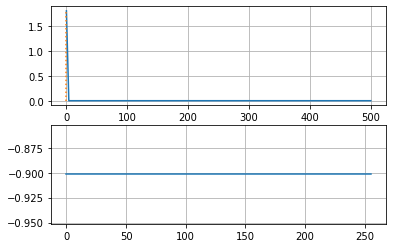

In [189]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(xf, yff)
plt.plot([xf[w],xf[w]],[0,yff.max()],linestyle=':')
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(data)
plt.grid(True)

In [121]:
'./data/P812_M050_2_B_FoG_trial_2_emg.csv'.split('/')[-1]

'P812_M050_2_B_FoG_trial_2_emg.csv'

In [149]:
freqs, power=signal.periodogram(data, 1e3)
total = (cumtrapz(power,freqs))
w=np.where(total>=(total[-1]/2))[0][0]

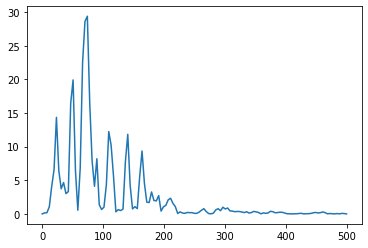

In [150]:
plt.plot(freqs, power)

In [38]:
feature_col = ['_IEMG','_MAV','_SSI','_VAR','_RMS',
               '_WL','_ZC','_SSC','_WAMP','_skew','_Acti','_AR','_HIST','_MDF']
ind = Data.columns.str.contains('_SSI')
Data.iloc[:,ind].max()

LEFT_TA_SSI     5.366227e+07
LEFT_TS_SSI     2.340434e+08
LEFT_BF_SSI     7.869578e+08
LEFT_RF_SSI     5.972622e+08
RIGHT_TA_SSI    5.507855e+07
RIGHT_TS_SSI    1.321042e+09
RIGHT_BF_SSI    4.847253e+07
RIGHT_RF_SSI    1.949695e+08
dtype: float32

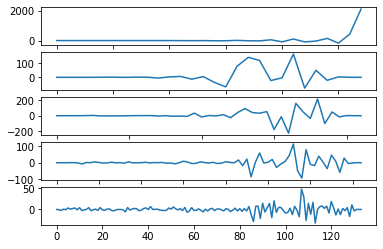

In [146]:
wa = pywt.wavedec(x[1,:,4],'db7',3)
j = 0
for i in wa:
    j += 1
    plt.subplot(5,1,j)
    plt.plot(i)
    

In [52]:
l = 0
for i in wa:
    l += len(i)
l

306

In [75]:
2**5

32

In [186]:
def mDWT(data):
    wa = pywt.wavedec(data,'db7',3)
    wa = np.concatenate(wa)
    N = len(wa)
    S = int(np.log2(N))
    M = []
    for i in range(S):
        C = N//(2**(i+1))-1
        #print(C)
        M.append(np.abs(wa[:C+1]).sum())
    return M
    
def compute_mDWT(data):
    N,M = data.shape[0::2]
    feature = []
    for i in range(N):
        temp = []
        for j in range(M):
            temp.extend(mDWT(data[i,:,j]))
        feature.append(temp)
    return feature

import warnings  
warnings.filterwarnings('error') 

def compute_MNF(data):
    N,M = data.shape[0::2]
    feature = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            freqs, power=signal.periodogram(data[i,:,j], 1e3)
            try:
                1/power.sum()
            except RuntimeWarning:
                print(i,j)
            else:
                feature[i,j] = freqs@power/power.sum()
    return feature

In [187]:
start = time.time()
a = dp.compute_mDWT_pd(x)
end = time.time()
t1 = end-start
start = time.time()
b = compute_MNF(x)
end = time.time()
t2 = end-start
print('1: %f'%t1)
print('2: %f'%t2)

123 4
124 4
1: 0.390952
2: 0.541551


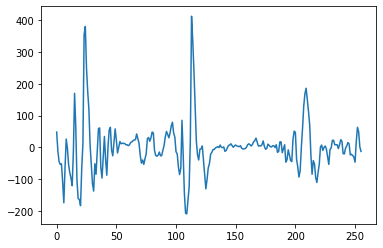

In [144]:
plt.plot(x[7,:,4])

In [218]:
emg_data.dropna().reset_index(drop=True)

,Time,Label1,Label2,LEFT_TA,LEFT_TS,LEFT_BF,LEFT_RF,RIGHT_TA,RIGHT_TS,RIGHT_BF,RIGHT_RF
0,0.000,0,0,-3,4,2,0,2.0,7.0,-1,1
1,0.001,0,0,2,3,-1,15,1.0,10.0,0,-1
2,0.002,0,0,-1,3,11,19,6.0,7.0,-2,5
3,0.003,0,0,0,2,3,13,-3.0,13.0,-2,0
4,0.004,0,0,-4,0,0,-2,-1.0,-6.0,-2,-6
...,...,...,...,...,...,...,...,...,...,...,...
23067,23.496,0,0,-21,0,36,-14,20.0,-7.0,0,5
23068,23.497,0,0,-26,-1,0,-12,49.0,-5.0,4,0
23069,23.498,0,0,-7,0,-32,0,60.0,-10.0,-2,-1
23070,23.499,0,0,-13,0,-46,7,43.0,1.0,-10,-4


In [161]:
len(emg_data)

23501